# FFN's milestone project 3 : Data Interpolation
Part of this code is taken (and modified from the original) from the DUDL course by Mike X Cohen.

course url : udemy.com/course/deeplearning_x/?couponCode=202305

project author : Chen Cohen Gershon

In [110]:
# libraries:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import seaborn as sns

<ipython-input-110-060e4b593c2a>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Data processing

In [111]:
# import the data:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
cols2zscore = cols2zscore.drop('residual sugar')

In [112]:
# randomly select 10 rows and change the residual sugar value to NaN:
indxes = np.random.choice(data.shape[0], 10)

# save the 10 values before the change:
original_values = data['residual sugar'].iloc[indxes]

# change the value:
data['residual sugar'].iloc[indxes] = np.NaN
data[cols2zscore].keys()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol', 'quality'],
      dtype='object')

# Re-organize the data: train/test in DataLoaders

In [113]:
dataT = torch.tensor( data[cols2zscore].values ).float()
labelsT = torch.tensor( data['residual sugar'].values ).float()

# split into train and test using the 10 row's with NaN as the test set:
test_data = dataT[indxes]
test_labels = torch.tensor( original_values.values )
test_labels = test_labels[:,None]

# Create a boolean mask for the rows to keep
mask = torch.ones(len(dataT), dtype=torch.bool)
mask[indxes] = 0

# Use boolean indexing to select the rows to keep
train_data = dataT[mask]
train_labels = labelsT[mask]
train_labels = train_labels[:,None]

train_dataTD = TensorDataset(train_data,train_labels)
test_dataTD  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 8
train_loader = DataLoader(train_dataTD,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataTD,batch_size=test_dataTD.tensors[0].shape[0])

data.shape, train_data.shape, train_labels.shape, test_data.shape, test_labels.shape

((1597, 12),
 torch.Size([1587, 11]),
 torch.Size([1587, 1]),
 torch.Size([10, 11]),
 torch.Size([10, 1]))

# Now, for the DL part:

In [114]:
class wineNet(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,32)

    ### hidden layers
    self.fc1 = nn.Linear(32,64)
    self.fc2 = nn.Linear(64,32)

    ### output layer
    self.output = nn.Linear(32,1)

  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [115]:
# function to create the model:
def createTheModel():

  net = wineNet()

  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(), lr=.001)

  return net, lossfun, optimizer

In [116]:
# function to train the model:
from tqdm.notebook import tqdm

numepochs = 350

def trainTheModel():

  net, lossfun, optimizer = createTheModel()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in tqdm(range(numepochs)):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return net, trainLoss, testLoss

# Train and test the model:

In [117]:
net, trainLoss, testLoss = trainTheModel()

  0%|          | 0/350 [00:00<?, ?it/s]

# Plots:

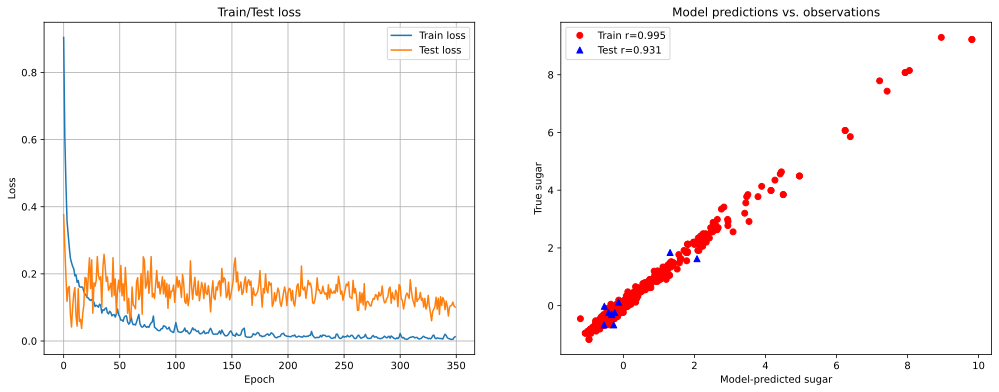

In [118]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = net(train_data)
yHatTest  = net(test_data)

ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()